In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari

In [15]:
def eval_clusters(true, pred, calc_acc=True):
    print("NMI: ", nmi(true, pred))
    print("ARI: ", ari(true, pred))
    
    if calc_acc:
        cm = confusion_matrix(true, pred)
        _, true_perm = linear_sum_assignment(-cm)
        true_permed = np.array([true_perm[x] for x in true])
        acc = np.mean(pred == true_permed)
        print("Accuracy: ", acc)

In [16]:
def ids_to_coo(ids):
    coo = np.zeros((len(ids), len(ids)))
    for u in np.unique(ids):
        mask = ids == u
        coo[np.ix_(mask, mask)] = 1
    return coo

In [47]:
run = 1240

# Load true clustering assingments
data, num_clusts = torch.load(f"outputs/sim{run}_true.p")
true_assigns = sum([[i] * j for i, j in enumerate(num_clusts)], start=[])

Found 524 samples out of 1000 that match the best assignment.


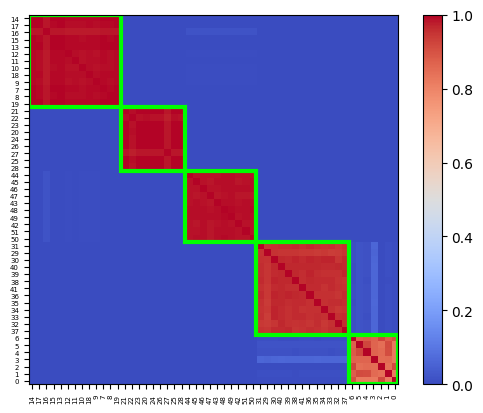

In [48]:
# Compute clustering from DPnSSM run 
assigns = pd.read_csv(f"outputs/sim{run}_assigns.csv", header=None).iloc[500:].reset_index(drop=True)
coos = np.stack([ids_to_coo(x) for _, x in assigns.iterrows()])
mean_coo = coos.mean(axis=0)
dists = np.linalg.norm(coos - mean_coo, axis=(1, 2))
min_dist_idx = np.argmin(dists)
match_idxs = np.where(np.all(coos == coos[min_dist_idx], axis=(1, 2)))[0]
print(f"Found {len(match_idxs)} samples out of {len(assigns)} that match the best assignment.")

# Recorder sample ids to match best assignment
reorder = assigns.loc[min_dist_idx].sort_values().index

# Plot cluster assignments
plt.imshow(mean_coo[np.ix_(reorder, reorder)], cmap="coolwarm")
plt.colorbar()

# Add chosen clustering in outline
counts = np.bincount(assigns.loc[min_dist_idx])
N = len(assigns.columns)
start = -0.5
for c in counts:
    rect = patches.Rectangle((start, start), c, c, linewidth=3, edgecolor='lime', facecolor='none')
    start += c
    plt.gca().add_patch(rect)
plt.yticks(np.arange(N), reorder, fontsize=5)
plt.xticks(np.arange(N), reorder, fontsize=5, rotation=90)
plt.show()

In [49]:
eval_clusters(true_assigns, assigns.loc[min_dist_idx])

NMI:  1.0
ARI:  1.0
Accuracy:  1.0
